In [605]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

### Functions

In [658]:
def get_weeks(year_start,year_end):
    # The date range that we query
    datelist = pd.date_range(f'{year_start}-01-01', f'{year_end+1}-01-01').to_series()

    # Extract year and week 
    year = datelist.apply(lambda x: x.strftime('%Y')).astype(int)
    week = datelist.apply(lambda x: x.strftime('%U')).astype(int)

    # Combine years and their weeks in one table
    data_years = pd.DataFrame(data=[year, week], index=['year', 'week']).T

    # Get number of weeks per year
    data_weeks = data_years.groupby(['year']).max().to_dict('index')

    # Get a list of weeks per year
    week_ranges=[]
    for year in data_weeks.keys():
        week_ranges.append(list(range(1,data_weeks[year]['week']+1)))

    # Create a dict with year and exact week numbers
    weeks_per_year = dict(zip(list(data_weeks.keys()), week_ranges))
    
    return weeks_per_year

In [660]:
def find_missing_weeks(data):
    year_start = data.year.min()
    year_end = data.year.max()
    
    weeks_per_year=get_weeks(year_start,year_end)
    actual_data = data.groupby('year')['week_number'].apply(set).apply(list)

    weeks_to_add={}
    for year in range(year_start,year_end+1):
        weeks1 = get_weeks(year_start,year_end)[year]
        weeks2 = actual_data[year]
        weeks_to_add[year] = (list(set(weeks1) - set(weeks2)))
        
    return weeks_to_add

In [608]:
def handle_missing_weeks(data):
    weeks_to_add = find_missing_weeks(data)
    
    for year in weeks_to_add.keys():
        for week in weeks_to_add[year]:
            data = data.append({'year':year, 'week_number':week, 'content':0}, ignore_index=True)
            
    return data.sort_values(['year', 'week_number']).reset_index(drop=True)

In [609]:
def get_relative_scores_per_year(data):
    new_data = pd.DataFrame()
    for year in data.year.unique():
        data_year = data[data['year']==year]
        
        scaler = MinMaxScaler()
        data_year['relative_yearly'] = scaler.fit_transform(np.array(data_year.content).reshape(-1, 1))*100
        new_data=pd.concat([new_data, data_year])
        
    return new_data

In [588]:
# def find_last_week_of_year(year, data):
#     return data.loc[data['year'] == year].week_number.max()


In [589]:
# def handle_week_zero(data):
#     year_min=data.year.min() #initial min year in dataset
    
#     data.loc[data['week_number'] == 0, 'year'] = data.year-1 # If week 0, make the row belong to the previous year
#     data = data[data.year>=year_min] # Ignore years that weren't initially in the dataset
#     data.loc[data['week_number'] == 0, 'week_number'] = find_last_week_of_year(data.year, data) # If week 0, replace it with week 52
#     data = data.groupby(['year','week_number']).sum().reset_index() # Merge rows with week 52 together under the same sum
# #     data = data[data.year>=2014] # Match filter of Google Trends query
# #     data = data.set_index('week_number')
#     return data.reset_index(drop=True)

In [611]:
def find_last_week_of_year(year):
    weeks_in_year = get_weeks(year,year)
    return max(weeks_in_year[year])

In [612]:
def handle_week_zero(data):
    data['prev_year']= data.year-1
    data['max_week_prev_year'] = data.prev_year.apply(find_last_week_of_year)
    
    year_update = data.loc[data['week_number'] == 0].prev_year
    week_update = data.loc[data['week_number'] == 0].max_week_prev_year

    
    data.loc[data['week_number'] == 0, 'year']  = year_update.values
    data.loc[data['week_number'] == 0, 'week_number']  = week_update.values
    
    data = data[data.year>=2014] # Match filter of Google Trends query
    
    data = data.groupby(['year','week_number']).sum().reset_index() # Merge rows with week MAX together under the same sum
    return data[['year', 'week_number', 'content']]


In [613]:
def scale_year_range(data, col, year_start, year_end):
    data_period = data[(data.year>=year_start) & (data.year<=year_end)]
    scaler = MinMaxScaler()
    data_period['relative_period'] = scaler.fit_transform(np.array(data_period[col]).reshape(-1, 1))*100
    return data_period

# News data analysis

In [634]:
news = pd.read_csv('dutch-news-articles.csv')
news = news[news['datetime']>='2014-01-01']
news.head(2)

,datetime,title,content,category,url
73955,2014-01-01 00:00:00,2014 knallend ingezet,Nieuwjaar is in het hele land met veel vuurwer...,Binnenland,https://nos.nl/artikel/592437-2014-knallend-in...
73956,2014-01-01 01:54:00,Brandweerlieden landelijk belaagd,De brandweer is vannacht op verschillende plaa...,Binnenland,https://nos.nl/artikel/592441-brandweerlieden-...


### Data preprocessing

In [635]:
# convert date for better usage
news['datetime'] = pd.to_datetime(news['datetime'])
news['date'] = pd.to_datetime(news['datetime'].dt.date)
news['year'] = news['datetime'].apply(lambda x: x.strftime('%Y')) 
news['year'] = news['year'].astype('int')
news['week_number'] = news.date.apply(lambda x: x.strftime('%U')).astype(int)
news.drop(['datetime'], axis=1, inplace=True)

In [636]:
# change order of df colums for better interpretation
first_column = news.pop('date')
second_column = news.pop('year')
third_column = news.pop('week_number')

news.insert(0, 'date', first_column)
news.insert(1, 'year', second_column)
news.insert(2, 'week_number', third_column)


In [637]:
# lowercase content column and replace some letters
news['content'] = news['content'].apply(lambda x: x.lower())
news['content'] = news.content.str.replace('ï','i')

In [638]:
news.tail(2)

,date,year,week_number,title,content,category,url
246455,2022-12-04,2022,49,Vulkaan op Java barst uit: rookpluim van 15 ki...,indonesische autoriteiten hebben de alarmfase ...,Buitenland,https://nos.nl//artikel/2455058-vulkaan-op-jav...
246456,2022-12-04,2022,49,Iran executeert vier mannen om werk voor inlic...,iran heeft vier mannen geëxecuteerd die ervan...,Buitenland,https://nos.nl//artikel/2455070-iran-executeer...


## Data augmentation

In [639]:
regional_labels = ['l1mburg', 
                   'nh nieuws', 
                   'omroep brabant', 
                   'omrop frylân', 
                   'omroep gelderland', 
                   'omroep west',
                   'omroep zeeland',
                   'rijnmond',
                   'rtv rijnmond',
                   'rtv drenthe',
                   'rtv noord',
                   'rtv oost',
                   'rtv utrecht'
                  ]

def contains_omroep(text):
    return [omroep for omroep in regional_labels if omroep in text]

drug_labels = ['cocaine',
                   'ghb',
                   'xtc'
                  ]

def contains_drug(text):
    return [drug for drug in drug_labels if drug in text]

In [640]:
# create 'omroep' and 'drugs' columns
news['omroep'] = news.content.apply(contains_omroep)
news['drugs'] = news.content.apply(contains_drug)

# add seperate columns for each drug
searchfor_cocaine = ['cocaine', 'cocaïne', 'Cocaine', 'Cocaïne']
searchfor_GHB = ['ghb', 'GHB']
searchfor_XTC = ['xtc', 'XTC']


news['cocaine'] = news.content.str.contains('cocaine')
news['ghb'] = news.content.str.contains('ghb')
news['xtc'] = news.content.str.contains('xtc')

## Data inspection

In [641]:
news[news.omroep.apply(len)>0].head(1)

,date,year,week_number,title,content,category,url,omroep,drugs,cocaine,ghb,xtc
73956,2014-01-01,2014,0,Brandweerlieden landelijk belaagd,de brandweer is vannacht op verschillende plaa...,Binnenland,https://nos.nl/artikel/592441-brandweerlieden-...,[omroep west],[],False,False,False


In [642]:
news[news.drugs.apply(len)>0].head(1)

,date,year,week_number,title,content,category,url,omroep,drugs,cocaine,ghb,xtc
74050,2014-01-03,2014,0,'Crackburgemeester' wil 2e termijn,burgemeester rob ford van toronto heeft zich k...,Buitenland,https://nos.nl/artikel/593027-crackburgemeeste...,[],[cocaine],True,False,False


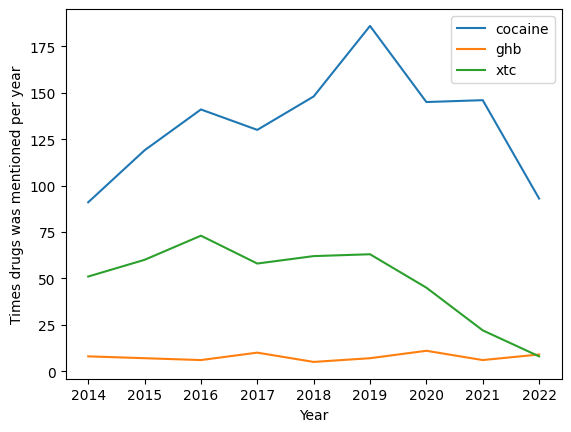

In [661]:
cocaine = news[news['cocaine'] == True].groupby(['year'])['cocaine'].count()
ghb = news[news['ghb'] == True].groupby(['year'])['ghb'].count()
xtc = news[news['xtc'] == True].groupby(['year'])['xtc'].count()

plt.plot(cocaine.index, cocaine.values, label='cocaine')
plt.plot(ghb.index, ghb.values, label='ghb')
plt.plot(xtc.index, xtc.values, label='xtc')
plt.xlabel('Year')
plt.ylabel('Times drugs was mentioned per year')
plt.legend()
plt.show()


In [662]:
news[news.week_number==53].year.unique()

array([2017])

### Create data subsets for dashboard

#### compute absolute scores for drug articles per week per drug

In [663]:
cocaine = pd.DataFrame(news[news['cocaine'] == True].groupby(['year', 'week_number'])['content'].count()).reset_index()
xtc = pd.DataFrame(news[news['xtc'] == True].groupby(['year', 'week_number'])['content'].count()).reset_index()
ghb = pd.DataFrame(news[news['ghb'] == True].groupby(['year', 'week_number'])['content'].count()).reset_index()

In [664]:
cocaine[cocaine.week_number==53]

,year,week_number,content
184,2017,53,1


#### Handle week zero

In [665]:
cocaine.head()

,year,week_number,content
0,2014,0,2
1,2014,1,2
2,2014,2,6
3,2014,3,1
4,2014,6,4


In [666]:
cocaine = handle_week_zero(cocaine)
xtc = handle_week_zero(xtc)
ghb = handle_week_zero(ghb)

In [667]:
cocaine.head()

,year,week_number,content
0,2014,1,2
1,2014,2,6
2,2014,3,1
3,2014,6,4
4,2014,8,2


In [669]:
cocaine[cocaine.week_number==53]

,year,week_number,content
183,2017,53,4


#### Handle missing weeks 
Make sure to have this in every notebook

In [670]:
cocaine = handle_missing_weeks(cocaine)
xtc = handle_missing_weeks(xtc)
ghb = handle_missing_weeks(ghb)

In [671]:
cocaine[cocaine.week_number==53].year.unique()

array([2017])

In [672]:
cocaine.head()

,year,week_number,content
0,2014,1,2
1,2014,2,6
2,2014,3,1
3,2014,4,0
4,2014,5,0


#### Compute relative scores for drug articles per week per drug

In [673]:
cocaine = get_relative_scores_per_year(cocaine)
xtc = get_relative_scores_per_year(xtc)
ghb = get_relative_scores_per_year(ghb)

In [674]:
cocaine.head()

,year,week_number,content,relative_yearly
0,2014,1,2,33.333333
1,2014,2,6,100.000000
2,2014,3,1,16.666667
3,2014,4,0,0.000000
4,2014,5,0,0.000000


In [675]:
cocaine[cocaine.week_number==53]

,year,week_number,content,relative_yearly
208,2017,53,4,44.444444


#### Scaling on all years 

In [676]:
cocaine = scale_year_range(cocaine, 'content', 2014, 2023)
xtc = scale_year_range(xtc, 'content', 2014, 2023)
ghb = scale_year_range(ghb, 'content', 2014, 2023)

In [677]:
cocaine.head()

,year,week_number,content,relative_yearly,relative_period
0,2014,1,2,33.333333,16.666667
1,2014,2,6,100.000000,50.000000
2,2014,3,1,16.666667,8.333333
3,2014,4,0,0.000000,0.000000
4,2014,5,0,0.000000,0.000000


## Save subsets as files

In [678]:
cocaine.to_csv("datasets/cocaine_NOS.csv", index=False)
xtc.to_csv("datasets/xtc_NOS.csv", index=False)
ghb.to_csv("datasets/ghb_NOS.csv", index=False)

In [679]:
cocaine[cocaine.week_number==53]

,year,week_number,content,relative_yearly,relative_period
208,2017,53,4,44.444444,33.333333
